# Colab FAQ

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the colab GPU for this assignment by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

# Setup PyTorch

All files will be stored at /content/csc421/a3/ folder


In [ ]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install Pillow
%mkdir -p ./content/csc421/a3/
%cd ./content/csc421/a3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/content/csc421/a3


# Helper code

## Utility functions

In [ ]:
%matplotlib inline

import os
import pdb
import argparse
import pickle as pkl
from pathlib import Path

from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from six.moves.urllib.request import urlretrieve
import tarfile
import pickle
import sys

import pandas as pd
import seaborn as sns


def get_file(
    fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"
):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print(fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def to_var(tensor, cuda):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

    Arguments:
        tensor: A Tensor object.
        cuda: A boolean flag indicating whether to use the GPU.

    Returns:
        A Variable object, on the GPU if cuda==True.
    """
    if cuda:
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


def create_dir_if_not_exists(directory):
    """Creates a directory if it doesn't already exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)


def save_loss_plot(train_losses, val_losses, opts):
    """Saves a plot of the training and validation loss curves."""
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(val_losses)), val_losses)
    plt.title("BS={}, nhid={}".format(opts.batch_size, opts.hidden_size), fontsize=20)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(opts.checkpoint_path, "loss_plot.pdf"))
    plt.close()


def save_loss_comparison_gru(l1, l2, o1, o2, fn, s=500):
    """Plot comparison of training and val loss curves from GRU runs.

    Arguments:
        l1: Tuple of lists containing training / val losses for model 1.
        l2: Tuple of lists containing training / val losses for model 2.
        o1: Options for model 1.
        o2: Options for model 2.
        fn: Output file name.
        s: Number of training iterations to average over.
    """
    mean_l1 = [np.mean(l1[0][i * s : (i + 1) * s]) for i in range(len(l1[0]) // s)]
    mean_l2 = [np.mean(l2[0][i * s : (i + 1) * s]) for i in range(len(l2[0]) // s)]

    plt.figure()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(range(len(mean_l1)), mean_l1, label="ds=" + o1.data_file_name)
    ax[0].plot(range(len(mean_l2)), mean_l2, label="ds=" + o2.data_file_name)
    ax[0].title.set_text("Train Loss | GRU Hidden Size = {}".format(o2.hidden_size))

    # Validation losses are assumed to be by epoch
    ax[1].plot(range(len(l1[1])), l1[1], label="ds=" + o1.data_file_name)
    ax[1].plot(range(len(l2[1])), l2[1], label="ds=" + o2.data_file_name)
    ax[1].title.set_text("Val Loss | GRU Hidden Size = {}".format(o2.hidden_size))

    ax[0].set_xlabel("Iterations (x{})".format(s), fontsize=10)
    ax[0].set_ylabel("Loss", fontsize=10)
    ax[1].set_xlabel("Epochs", fontsize=10)
    ax[1].set_ylabel("Loss", fontsize=10)
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="upper right")

    fig.suptitle("GRU Performance by Dataset", fontsize=14)
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.legend()

    plt_path = "./loss_plot_{}.pdf".format(fn)
    plt.savefig(plt_path)
    print(f"Plot saved to: {Path(plt_path).resolve()}")


def save_loss_comparison_by_dataset(l1, l2, l3, l4, o1, o2, o3, o4, fn, s=500):
    """Plot comparison of training and validation loss curves from all four
    runs in Part 3, comparing by dataset while holding hidden size constant.

    Models within each pair (l1, l2) and (l3, l4) have the same hidden sizes.

    Arguments:
        l1: Tuple of lists containing training / val losses for model 1.
        l2: Tuple of lists containing training / val losses for model 2.
        l3: Tuple of lists containing training / val losses for model 3.
        l4: Tuple of lists containing training / val losses for model 4.
        o1: Options for model 1.
        o2: Options for model 2.
        o3: Options for model 3.
        o4: Options for model 4.
        fn: Output file name.
        s: Number of training iterations to average over.
    """
    mean_l1 = [np.mean(l1[0][i * s : (i + 1) * s]) for i in range(len(l1[0]) // s)]
    mean_l2 = [np.mean(l2[0][i * s : (i + 1) * s]) for i in range(len(l2[0]) // s)]
    mean_l3 = [np.mean(l3[0][i * s : (i + 1) * s]) for i in range(len(l3[0]) // s)]
    mean_l4 = [np.mean(l4[0][i * s : (i + 1) * s]) for i in range(len(l4[0]) // s)]

    plt.figure()
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    ax[0][0].plot(range(len(mean_l1)), mean_l1, label="ds=" + o1.data_file_name)
    ax[0][0].plot(range(len(mean_l2)), mean_l2, label="ds=" + o2.data_file_name)
    ax[0][0].title.set_text(
        "Train Loss | Model Hidden Size = {}".format(o1.hidden_size)
    )

    # Validation losses are assumed to be by epoch
    ax[0][1].plot(range(len(l1[1])), l1[1], label="ds=" + o1.data_file_name)
    ax[0][1].plot(range(len(l2[1])), l2[1], label="ds=" + o2.data_file_name)
    ax[0][1].title.set_text("Val Loss | Model Hidden Size = {}".format(o1.hidden_size))

    ax[1][0].plot(range(len(mean_l3)), mean_l3, label="ds=" + o3.data_file_name)
    ax[1][0].plot(range(len(mean_l4)), mean_l4, label="ds=" + o4.data_file_name)
    ax[1][0].title.set_text(
        "Train Loss | Model Hidden Size = {}".format(o3.hidden_size)
    )

    ax[1][1].plot(range(len(l3[1])), l3[1], label="ds=" + o3.data_file_name)
    ax[1][1].plot(range(len(l4[1])), l4[1], label="ds=" + o4.data_file_name)
    ax[1][1].title.set_text("Val Loss | Model Hidden Size = {}".format(o4.hidden_size))

    for i in range(2):
        ax[i][0].set_xlabel("Iterations (x{})".format(s), fontsize=10)
        ax[i][0].set_ylabel("Loss", fontsize=10)
        ax[i][1].set_xlabel("Epochs", fontsize=10)
        ax[i][1].set_ylabel("Loss", fontsize=10)
        ax[i][0].legend(loc="upper right")
        ax[i][1].legend(loc="upper right")

    fig.suptitle("Performance by Dataset Size", fontsize=16)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.legend()
    plt.savefig("./loss_plot_{}.pdf".format(fn))
    # plt.close()
    plt.show()


def save_loss_comparison_by_hidden(l1, l2, l3, l4, o1, o2, o3, o4, fn, s=500):
    """Plot comparison of training and validation loss curves from all four
    runs in Part 3, comparing by hidden size while holding dataset constant.

    Models within each pair (l1, l3) and (l2, l4) have the same dataset.

    Arguments:
        l1: Tuple of lists containing training / val losses for model 1.
        l2: Tuple of lists containing training / val losses for model 2.
        l3: Tuple of lists containing training / val losses for model 3.
        l4: Tuple of lists containing training / val losses for model 4.
        o1: Options for model 1.
        o2: Options for model 2.
        o3: Options for model 3.
        o4: Options for model 4.
        fn: Output file name.
        s: Number of training iterations to average over.
    """
    mean_l1 = [np.mean(l1[0][i * s : (i + 1) * s]) for i in range(len(l1[0]) // s)]
    mean_l2 = [np.mean(l2[0][i * s : (i + 1) * s]) for i in range(len(l2[0]) // s)]
    mean_l3 = [np.mean(l3[0][i * s : (i + 1) * s]) for i in range(len(l3[0]) // s)]
    mean_l4 = [np.mean(l4[0][i * s : (i + 1) * s]) for i in range(len(l4[0]) // s)]

    plt.figure()
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    ax[0][0].plot(range(len(mean_l1)), mean_l1, label="hid_size=" + str(o1.hidden_size))
    ax[0][0].plot(range(len(mean_l3)), mean_l3, label="hid_size=" + str(o3.hidden_size))
    ax[0][0].title.set_text("Train Loss | Dataset = " + o1.data_file_name)

    # Validation losses are assumed to be by epoch
    ax[0][1].plot(range(len(l1[1])), l1[1], label="hid_size=" + str(o1.hidden_size))
    ax[0][1].plot(range(len(l3[1])), l3[1], label="hid_size=" + str(o3.hidden_size))
    ax[0][1].title.set_text("Val Loss | Dataset = " + o1.data_file_name)

    ax[1][0].plot(range(len(mean_l2)), mean_l2, label="hid_size=" + str(o2.hidden_size))
    ax[1][0].plot(range(len(mean_l4)), mean_l4, label="hid_size=" + str(o4.hidden_size))
    ax[1][0].title.set_text("Train Loss | Dataset = " + o3.data_file_name)

    ax[1][1].plot(range(len(l2[1])), l2[1], label="hid_size=" + str(o2.hidden_size))
    ax[1][1].plot(range(len(l4[1])), l4[1], label="hid_size=" + str(o4.hidden_size))
    ax[1][1].title.set_text("Val Loss | Dataset = " + o4.data_file_name)

    for i in range(2):
        ax[i][0].set_xlabel("Iterations (x{})".format(s), fontsize=10)
        ax[i][0].set_ylabel("Loss", fontsize=10)
        ax[i][1].set_xlabel("Epochs", fontsize=10)
        ax[i][1].set_ylabel("Loss", fontsize=10)
        ax[i][0].legend(loc="upper right")
        ax[i][1].legend(loc="upper right")

    fig.suptitle("Performance by Hidden State Size", fontsize=16)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.legend()
    plt.savefig("./loss_plot_{}.pdf".format(fn))
    # plt.close()
    plt.show()



def checkpoint(encoder, decoder, idx_dict, opts):
    """Saves the current encoder and decoder models, along with idx_dict, which
    contains the char_to_index and index_to_char mappings, and the start_token
    and end_token values.
    """
    with open(os.path.join(opts.checkpoint_path, "encoder.pt"), "wb") as f:
        torch.save(encoder, f)

    with open(os.path.join(opts.checkpoint_path, "decoder.pt"), "wb") as f:
        torch.save(decoder, f)

    with open(os.path.join(opts.checkpoint_path, "idx_dict.pkl"), "wb") as f:
        pkl.dump(idx_dict, f)

## Data loader

In [ ]:
def read_lines(filename):
    """Read a file and split it into lines."""
    lines = open(filename).read().strip().lower().split("\n")
    return lines


def read_pairs(filename):
    """Reads lines that consist of two words, separated by a space.

    Returns:
        source_words: A list of the first word in each line of the file.
        target_words: A list of the second word in each line of the file.
    """
    lines = read_lines(filename)
    source_words, target_words = [], []
    for line in lines:
        line = line.strip()
        if line:
            source, target = line.split()
            source_words.append(source)
            target_words.append(target)
    return source_words, target_words


def all_alpha_or_dash(s):
    """Helper function to check whether a string is alphabetic, allowing dashes '-'."""
    return all(c.isalpha() or c == "-" for c in s)


def filter_lines(lines):
    """Filters lines to consist of only alphabetic characters or dashes "-"."""
    return [line for line in lines if all_alpha_or_dash(line)]


def load_data(file_name):
    """Loads (English, Pig-Latin) word pairs, and creates mappings from characters to indexes."""
    """Loads (English, Pig-Latin) word pairs, and creates mappings from characters to indexes."""
    path = "./data/{}.txt".format(file_name)
    source_lines, target_lines = read_pairs(path)

    # Filter lines
    source_lines = filter_lines(source_lines)
    target_lines = filter_lines(target_lines)

    all_characters = set("".join(source_lines)) | set("".join(target_lines))
    # Create a dictionary mapping each character to a unique index
    char_to_index = {
        char: index for (index, char) in enumerate(sorted(list(all_characters)))
    }

    # Add start, end, and  tokens to the dictionary
    start_token = len(char_to_index)
    end_token = len(char_to_index) + 1
    end_prompt_token = len(char_to_index) + 2
    char_to_index["SOS"] = start_token
    char_to_index["EOS"] = end_token
    char_to_index["EOP"] = end_prompt_token

    # Create the inverse mapping, from indexes to characters (used to decode the model's predictions)
    index_to_char = {index: char for (char, index) in char_to_index.items()}

    # Store the final size of the vocabulary
    vocab_size = len(char_to_index)

    line_pairs = list(set(zip(source_lines, target_lines)))  # Python 3
    # import pdb; pdb.set_trace()
    idx_dict = {
        "char_to_index": char_to_index,
        "index_to_char": index_to_char,
        "start_token": start_token,
        "end_token": end_token,
        "end_prompt_token": end_prompt_token
    }

    return line_pairs, vocab_size, idx_dict


def create_dict(pairs):
    """Creates a mapping { (source_length, target_length): [list of (source, target) pairs]
    This is used to make batches: each batch consists of two parallel tensors, one containing
    all source indexes and the other containing all corresponding target indexes.
    Within a batch, all the source words are the same length, and all the target words are
    the same length.
    """
    unique_pairs = list(set(pairs))  # Find all unique (source, target) pairs

    d = defaultdict(list)
    for (s, t) in unique_pairs:
        d[(len(s), len(t))].append((s, t))

    return d

## Download dataset

In [ ]:
######################################################################
# Download Translation datasets
######################################################################
data_fpath = get_file(
    fname="pig_latin_small.txt",
    origin="http://www.cs.toronto.edu/~jba/pig_latin_small.txt",
    untar=False,
)

data_fpath = get_file(
    fname="pig_latin_large.txt",
    origin="http://www.cs.toronto.edu/~jba/pig_latin_large.txt",
    untar=False,
)

data/pig_latin_small.txt
data/pig_latin_large.txt


# Part 1: Scaled Dot Production Attention

## Training and evaluation code

In [ ]:
def string_to_index_list(s, char_to_index, end_token):
    """Converts a sentence into a list of indexes (for each character)."""
    return [char_to_index[char] for char in s] + [
        end_token
    ]  # Adds the end token to each index list


def translate_sentence(sentence, encoder, decoder, idx_dict, opts):
    """Translates a sentence from English to Pig-Latin, by splitting the sentence into
    words (whitespace-separated), running the encoder-decoder model to translate each
    word independently, and then stitching the words back together with spaces between them.
    """
    if idx_dict is None:
        line_pairs, vocab_size, idx_dict = load_data(opts["data_file_name"])
    return " ".join(
        [translate(word, encoder, decoder, idx_dict, opts) for word in sentence.split()]
    )


def translate(input_string, encoder, decoder, idx_dict, opts):
    """Translates a given string from English to Pig-Latin."""

    char_to_index = idx_dict["char_to_index"]
    index_to_char = idx_dict["index_to_char"]
    start_token = idx_dict["start_token"]
    end_token = idx_dict["end_token"]

    max_generated_chars = 20
    gen_string = ""

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(
        torch.LongTensor(indexes).unsqueeze(0), opts.cuda
    )  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_last_hidden = encoder(indexes)

    decoder_hidden = encoder_last_hidden
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    for i in range(max_generated_chars):
        ## slow decoding, recompute everything at each time
        decoder_outputs, attention_weights = decoder(
            decoder_inputs, encoder_annotations, decoder_hidden
        )

        generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
        ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
        ni = ni[-1]  # latest output token

        decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)

        if ni == end_token:
            break
        else:
            gen_string = "".join(
                [
                    index_to_char[int(item)]
                    for item in generated_words.cpu().numpy().reshape(-1)
                ]
            )

    return gen_string


def visualize_attention(input_string, encoder, decoder, idx_dict, opts):
    """Generates a heatmap to show where attention is focused in each decoder step."""
    if idx_dict is None:
        line_pairs, vocab_size, idx_dict = load_data(opts["data_file_name"])
    char_to_index = idx_dict["char_to_index"]
    index_to_char = idx_dict["index_to_char"]
    start_token = idx_dict["start_token"]
    end_token = idx_dict["end_token"]

    max_generated_chars = 20
    gen_string = ""

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(
        torch.LongTensor(indexes).unsqueeze(0), opts.cuda
    )  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_hidden = encoder(indexes)

    decoder_hidden = encoder_hidden
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    produced_end_token = False

    for i in range(max_generated_chars):
        ## slow decoding, recompute everything at each time
        decoder_outputs, attention_weights = decoder(
            decoder_inputs, encoder_annotations, decoder_hidden
        )
        generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
        ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
        ni = ni[-1]  # latest output token

        decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)

        if ni == end_token:
            break
        else:
            gen_string = "".join(
                [
                    index_to_char[int(item)]
                    for item in generated_words.cpu().numpy().reshape(-1)
                ]
            )

    if isinstance(attention_weights, tuple):
        ## transformer's attention mweights
        attention_weights, self_attention_weights = attention_weights

    all_attention_weights = attention_weights.data.cpu().numpy()

    for i in range(len(all_attention_weights)):
        attention_weights_matrix = all_attention_weights[i].squeeze()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(attention_weights_matrix, cmap="bone")
        fig.colorbar(cax)

        # Set up axes
        ax.set_yticklabels([""] + list(input_string) + ["EOS"], rotation=90)
        ax.set_xticklabels(
            [""] + list(gen_string) + (["EOS"] if produced_end_token else [])
        )

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        # Add title
        plt.xlabel("Attention weights to the source sentence in layer {}".format(i + 1))
        plt.tight_layout()
        plt.grid("off")
        plt.show()

    return gen_string


def compute_loss(data_dict, encoder, decoder, idx_dict, criterion, optimizer, opts):
    """Train/Evaluate the model on a dataset.

    Arguments:
        data_dict: The validation/test word pairs, organized by source and target lengths.
        encoder: An encoder model to produce annotations for each step of the input sequence.
        decoder: A decoder model (with or without attention) to generate output tokens.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Train the weights if an optimizer is given. None if only evaluate the model.
        opts: The command-line arguments.

    Returns:
        mean_loss: The average loss over all batches from data_dict.
    """
    start_token = idx_dict["start_token"]
    end_token = idx_dict["end_token"]
    char_to_index = idx_dict["char_to_index"]

    losses = []
    for key in data_dict:
        input_strings, target_strings = zip(*data_dict[key])
        input_tensors = [
            torch.LongTensor(string_to_index_list(s, char_to_index, end_token))
            for s in input_strings
        ]
        target_tensors = [
            torch.LongTensor(string_to_index_list(s, char_to_index, end_token))
            for s in target_strings
        ]

        num_tensors = len(input_tensors)
        num_batches = int(np.ceil(num_tensors / float(opts.batch_size)))

        for i in range(num_batches):

            start = i * opts.batch_size
            end = start + opts.batch_size

            inputs = to_var(torch.stack(input_tensors[start:end]), opts.cuda)
            targets = to_var(torch.stack(target_tensors[start:end]), opts.cuda)

            # The batch size may be different in each epoch
            BS = inputs.size(0)

            encoder_annotations, encoder_hidden = encoder(inputs)

            # The last hidden state of the encoder becomes the first hidden state of the decoder
            decoder_hidden = encoder_hidden

            start_vector = (
                torch.ones(BS).long().unsqueeze(1) * start_token
            )  # BS x 1 --> 16x1  CHECKED
            decoder_input = to_var(start_vector, opts.cuda)  # BS x 1 --> 16x1  CHECKED

            loss = 0.0

            seq_len = targets.size(1)  # Gets seq_len from BS x seq_len

            decoder_inputs = torch.cat(
                [decoder_input, targets[:, 0:-1]], dim=1
            )  # Gets decoder inputs by shifting the targets to the right

            decoder_outputs, attention_weights = decoder(
                decoder_inputs, encoder_annotations, decoder_hidden
            )
            decoder_outputs_flatten = decoder_outputs.view(-1, decoder_outputs.size(2))
            targets_flatten = targets.view(-1)

            loss = criterion(decoder_outputs_flatten, targets_flatten)

            losses.append(loss.item())

            ## training if an optimizer is provided
            if optimizer:
                # Zero gradients
                optimizer.zero_grad()
                # Compute gradients
                loss.backward()
                # Update the parameters of the encoder and decoder
                optimizer.step()

    return losses


def training_loop(
    train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts
):
    """Runs the main training loop; evaluates the model on the val set every epoch.
        * Prints training and val loss each epoch.
        * Prints qualitative translation results each epoch using TEST_SENTENCE
        * Saves an attention map for TEST_WORD_ATTN each epoch
        * Returns loss curves for comparison

    Arguments:
        train_dict: The training word pairs, organized by source and target lengths.
        val_dict: The validation word pairs, organized by source and target lengths.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        encoder: An encoder model to produce annotations for each step of the input sequence.
        decoder: A decoder model (with or without attention) to generate output tokens.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Implements a step rule to update the parameters of the encoder and decoder.
        opts: The command-line arguments.

    Returns:
        losses: Lists containing training and validation loss curves.
    """

    start_token = idx_dict["start_token"]
    end_token = idx_dict["end_token"]
    char_to_index = idx_dict["char_to_index"]

    loss_log = open(os.path.join(opts.checkpoint_path, "loss_log.txt"), "w")

    best_val_loss = 1e6
    train_losses = []
    val_losses = []

    mean_train_losses = []
    mean_val_losses = []

    early_stopping_counter = 0

    for epoch in range(opts.nepochs):

        optimizer.param_groups[0]["lr"] *= opts.lr_decay

        train_loss = compute_loss(
            train_dict, encoder, decoder, idx_dict, criterion, optimizer, opts
        )
        val_loss = compute_loss(
            val_dict, encoder, decoder, idx_dict, criterion, None, opts
        )

        mean_train_loss = np.mean(train_loss)
        mean_val_loss = np.mean(val_loss)

        if mean_val_loss < best_val_loss:
            checkpoint(encoder, decoder, idx_dict, opts)
            best_val_loss = mean_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > opts.early_stopping_patience:
            print(
                "Validation loss has not improved in {} epochs, stopping early".format(
                    opts.early_stopping_patience
                )
            )
            print("Obtained lowest validation loss of: {}".format(best_val_loss))
            return (train_losses, mean_val_losses)

        gen_string = translate_sentence(TEST_SENTENCE, encoder, decoder, idx_dict, opts)
        print(
            "Epoch: {:3d} | Train loss: {:.3f} | Val loss: {:.3f} | Gen: {:20s}".format(
                epoch, mean_train_loss, mean_val_loss, gen_string
            )
        )

        loss_log.write("{} {} {}\n".format(epoch, train_loss, val_loss))
        loss_log.flush()

        train_losses += train_loss
        val_losses += val_loss

        mean_train_losses.append(mean_train_loss)
        mean_val_losses.append(mean_val_loss)

        save_loss_plot(mean_train_losses, mean_val_losses, opts)

    print("Obtained lowest validation loss of: {}".format(best_val_loss))
    return (train_losses, mean_val_losses)


def print_data_stats(line_pairs, vocab_size, idx_dict):
    """Prints example word pairs, the number of data points, and the vocabulary."""
    print("=" * 80)
    print("Data Stats".center(80))
    print("-" * 80)
    for pair in line_pairs[:5]:
        print(pair)
    print("Num unique word pairs: {}".format(len(line_pairs)))
    print("Vocabulary: {}".format(idx_dict["char_to_index"].keys()))
    print("Vocab size: {}".format(vocab_size))
    print("=" * 80)


def train(opts):
    line_pairs, vocab_size, idx_dict = load_data(opts["data_file_name"])
    print_data_stats(line_pairs, vocab_size, idx_dict)

    # Split the line pairs into an 80% train and 20% val split
    num_lines = len(line_pairs)
    num_train = int(0.8 * num_lines)
    train_pairs, val_pairs = line_pairs[:num_train], line_pairs[num_train:]

    # Group the data by the lengths of the source and target words, to form batches
    train_dict = create_dict(train_pairs)
    val_dict = create_dict(val_pairs)

    ##########################################################################
    ### Setup: Create Encoder, Decoder, Learning Criterion, and Optimizers ###
    ##########################################################################
    encoder = TransformerEncoder(
        vocab_size=vocab_size,
        hidden_size=opts.hidden_size,
        num_layers=opts.num_transformer_layers,
        opts=opts,
    )

    decoder = TransformerDecoder(
        vocab_size=vocab_size,
        hidden_size=opts.hidden_size,
        num_layers=opts.num_transformer_layers,
    )

    #### setup checkpoint path
    model_name = "encoder-decoder-h{}-bs{}-{}".format(
        opts.hidden_size, opts.batch_size, opts.data_file_name
    )
    opts.checkpoint_path = model_name
    create_dir_if_not_exists(opts.checkpoint_path)
    ####

    if opts.cuda:
        encoder.cuda()
        decoder.cuda()
        print("Moved models to GPU!")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(decoder.parameters()), lr=opts.learning_rate
    )

    try:
        losses = training_loop(
            train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts
        )
    except KeyboardInterrupt:
        print("Exiting early from training.")
        return encoder, decoder, losses

    return encoder, decoder, losses


def print_opts(opts):
    """Prints the values of all command-line arguments."""
    print("=" * 80)
    print("Opts".center(80))
    print("-" * 80)
    for key in opts.__dict__:
        print("{:>30}: {:<30}".format(key, opts.__dict__[key]).center(80))
    print("=" * 80)

## Step 1: Implement scaled dot-product attention

In the next cell, you will implement the [scaled dot-product attention](https://paperswithcode.com/method/scaled) mechanism. See the assignment handouts for details.

In [ ]:
class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=2)
        self.scaling_factor = torch.rsqrt(
            torch.tensor(self.hidden_size, dtype=torch.float)
        )

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x k)

            The output must be a softmax weighting over the seq_len annotations.
        """

        batch_size = queries.shape[0]
        queries = queries.view(batch_size, -1, self.hidden_size)
        q = self.Q(queries)
        k = self.K(keys)
        v = self.V(values)

        unnormalized_attention = torch.bmm(q, k.transpose(1, 2)) * self.scaling_factor
        attention_weights = self.softmax(unnormalized_attention)

        context = torch.bmm(attention_weights, v)
        return context, attention_weights

## Step 2: Implement causal dot-product Attention


Now, implement the casual scaled dot-product attention mechanism. It will be very similar to your implementation for `ScaledDotAttention`. The additional step is to mask out the attention to future timesteps so this attention mechanism can be used in a decoder. See the assignment handouts for details.

In [ ]:
class CausalScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(CausalScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size
        self.neg_inf = torch.tensor(-1e7)

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=2)
        self.scaling_factor = torch.rsqrt(
            torch.tensor(self.hidden_size, dtype=torch.float)
        )

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x k)

            The output must be a softmax weighting over the seq_len annotations.
        """

        batch_size = queries.shape[0]
        queries = queries.view(batch_size, -1, self.hidden_size)
        q = self.Q(queries)
        k = self.K(keys)
        v = self.V(values)
        unnormalized_attention = torch.bmm(q, k.transpose(1, 2)) * self.scaling_factor
        mask = torch.triu(self.neg_inf.repeat(unnormalized_attention.shape), diagonal=1).to(unnormalized_attention.device)
        unnormalized_attention = unnormalized_attention + mask
        attention_weights = self.softmax(unnormalized_attention)
        context = torch.bmm(attention_weights, v)
        return context, attention_weights

## Step 3: Transformer encoder and decoder

The following cells provide an implementation of the transformer encoder and decoder that use your `ScaledDotAttention` and `CausalScaledDotAttention`. Please read through them to understand what they are doing.

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, opts):
        super(TransformerEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.opts = opts

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.self_attentions = nn.ModuleList(
            [
                ScaledDotAttention(
                    hidden_size=hidden_size,
                )
                for i in range(self.num_layers)
            ]
        )
        self.attention_mlps = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU(),
                )
                for i in range(self.num_layers)
            ]
        )

        self.positional_encodings = self.create_positional_encodings()

    def forward(self, inputs):
        """Forward pass of the encoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all time steps in the sequence. (batch_size x seq_len)

        Returns:
            annotations: The hidden states computed at each step of the input sequence. (batch_size x seq_len x hidden_size)
            None: Used to conform to standard encoder return signature.
            None: Used to conform to standard encoder return signature.
        """
        batch_size, seq_len = inputs.size()

        encoded = self.embedding(inputs)  # batch_size x seq_len x hidden_size

        # Add positinal embeddings from self.create_positional_encodings. (a'la https://arxiv.org/pdf/1706.03762.pdf, section 3.5)
        encoded = encoded + self.positional_encodings[:seq_len]

        annotations = encoded
        for i in range(self.num_layers):
            new_annotations, self_attention_weights = self.self_attentions[i](
                annotations, annotations, annotations
            )  # batch_size x seq_len x hidden_size
            residual_annotations = annotations + new_annotations
            new_annotations = self.attention_mlps[i](residual_annotations)
            annotations = residual_annotations + new_annotations

        # Transformer encoder does not have a last hidden or cell layer.
        return annotations, None
        # return annotations, None, None
    def create_positional_encodings(self, max_seq_len=1000):
        """Creates positional encodings for the inputs.

        Arguments:
            max_seq_len: a number larger than the maximum string length we expect to encounter during training

        Returns:
            pos_encodings: (max_seq_len, hidden_dim) Positional encodings for a sequence with length max_seq_len.
        """
        pos_indices = torch.arange(max_seq_len)[..., None]
        dim_indices = torch.arange(self.hidden_size // 2)[None, ...]
        exponents = (2 * dim_indices).float() / (self.hidden_size)
        trig_args = pos_indices / (10000**exponents)
        sin_terms = torch.sin(trig_args)
        cos_terms = torch.cos(trig_args)

        pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
        pos_encodings[:, 0::2] = sin_terms
        pos_encodings[:, 1::2] = cos_terms

        if self.opts.cuda:
            pos_encodings = pos_encodings.cuda()

        return pos_encodings

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.num_layers = num_layers

        self.self_attentions = nn.ModuleList(
            [
                CausalScaledDotAttention(
                    hidden_size=hidden_size,
                )
                for i in range(self.num_layers)
            ]
        )
        self.encoder_attentions = nn.ModuleList(
            [
                ScaledDotAttention(
                    hidden_size=hidden_size,
                )
                for i in range(self.num_layers)
            ]
        )
        self.attention_mlps = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU(),
                )
                for i in range(self.num_layers)
            ]
        )
        self.out = nn.Linear(hidden_size, vocab_size)

        self.positional_encodings = self.create_positional_encodings()

    def forward(self, inputs, annotations, hidden_init):
        """Forward pass of the attention-based decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
            annotations: The encoder hidden states for each step of the input.
                         sequence. (batch_size x seq_len x hidden_size)
            hidden_init: Not used in the transformer decoder
        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """

        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size

        embed = embed + self.positional_encodings[:seq_len]

        encoder_attention_weights_list = []
        self_attention_weights_list = []
        contexts = embed
        for i in range(self.num_layers):
            new_contexts, self_attention_weights = self.self_attentions[i](
                contexts, contexts, contexts
            )  # batch_size x seq_len x hidden_size
            residual_contexts = contexts + new_contexts
            new_contexts, encoder_attention_weights = self.encoder_attentions[i](
                residual_contexts, annotations, annotations
            )  # batch_size x seq_len x hidden_size
            residual_contexts = residual_contexts + new_contexts
            new_contexts = self.attention_mlps[i](residual_contexts)
            contexts = residual_contexts + new_contexts

            encoder_attention_weights_list.append(encoder_attention_weights)
            self_attention_weights_list.append(self_attention_weights)

        output = self.out(contexts)
        encoder_attention_weights = torch.stack(encoder_attention_weights_list)
        self_attention_weights = torch.stack(self_attention_weights_list)

        return output, (encoder_attention_weights, self_attention_weights)

    def create_positional_encodings(self, max_seq_len=1000):
        """Creates positional encodings for the inputs.

        Arguments:
            max_seq_len: a number larger than the maximum string length we expect to encounter during training

        Returns:
            pos_encodings: (max_seq_len, hidden_dim) Positional encodings for a sequence with length max_seq_len.
        """
        pos_indices = torch.arange(max_seq_len)[..., None]
        dim_indices = torch.arange(self.hidden_size // 2)[None, ...]
        exponents = (2 * dim_indices).float() / (self.hidden_size)
        trig_args = pos_indices / (10000**exponents)
        sin_terms = torch.sin(trig_args)
        cos_terms = torch.cos(trig_args)

        pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
        pos_encodings[:, 0::2] = sin_terms
        pos_encodings[:, 1::2] = cos_terms

        pos_encodings = pos_encodings.cuda()

        return pos_encodings


## Step 4: Training and analysis (with scaled dot-product attention)

Now we will train a (simplified) transformer encoder-decoder model.

First, we train our smaller model on the small dataset. Use this model to answer Question 4 in the handout.

In [ ]:
use_cuda = torch.cuda.is_available()
TEST_SENTENCE = "the air conditioning is working"

trans32_args_s = AttrDict()
args_dict = {
    "data_file_name": "pig_latin_small",
    "cuda": use_cuda,
    "nepochs": 100,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 100,
    "lr_decay": 0.99,
    "batch_size": 64,
    "hidden_size": 32,
    "num_transformer_layers": 4,
}


trans32_args_s.update(args_dict)
print_opts(trans32_args_s)

trans32_encoder_s, trans32_decoder_s, trans32_losses_s = train(trans32_args_s)

translated = translate_sentence(
    TEST_SENTENCE, trans32_encoder_s, trans32_decoder_s, None, trans32_args_s
)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 32                                     
                 num_transformer_layers: 4                                      
                            

In [ ]:
TEST_SENTENCE = "the air conditioning is working"
translated = translate_sentence(
    TEST_SENTENCE, trans32_encoder_s, trans32_decoder_s, None, trans32_args_s
)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the air conditioning is working 
translated:	ethay arway odditingcay isway orkingway


In the following cells, we investigate the effects of increasing model size and dataset size on the training / validation curves and generalization of the Transformer. We will increase hidden size to 64, and also increase dataset size. Include the best achieved validation loss in your report.

In [ ]:
TEST_SENTENCE = "the air conditioning is working"

trans32_args_l = AttrDict()
args_dict = {
    "data_file_name": "pig_latin_large",  # Increased data set size
    "cuda": True,
    "nepochs": 100,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 10,
    "lr_decay": 0.99,
    "batch_size": 512,
    "hidden_size": 32,
    "num_transformer_layers": 3,
}
trans32_args_l.update(args_dict)
print_opts(trans32_args_l)

trans32_encoder_l, trans32_decoder_l, trans32_losses_l = train(trans32_args_l)

translated = translate_sentence(
    TEST_SENTENCE, trans32_encoder_l, trans32_decoder_l, None, trans32_args_l
)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_large                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 10                                     
                               lr_decay: 0.99                                   
                             batch_size: 512                                    
                            hidden_size: 32                                     
                 num_transformer_layers: 3                                      
                            

In [ ]:
TEST_SENTENCE = "the air conditioning is working"

trans64_args_s = AttrDict()
args_dict = {
    "data_file_name": "pig_latin_small",
    "cuda": True,
    "nepochs": 50,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 20,
    "lr_decay": 0.99,
    "batch_size": 64,
    "hidden_size": 64,  # Increased model size
    "num_transformer_layers": 3,
}
trans64_args_s.update(args_dict)
print_opts(trans64_args_s)

trans64_encoder_s, trans64_decoder_s, trans64_losses_s = train(trans64_args_s)

translated = translate_sentence(
    TEST_SENTENCE, trans64_encoder_s, trans64_decoder_s, None, trans64_args_s
)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 20                                     
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 64                                     
                 num_transformer_layers: 3                                      
                            

In [ ]:
TEST_SENTENCE = "the air conditioning is working"

trans64_args_l = AttrDict()
args_dict = {
    "data_file_name": "pig_latin_large",  # Increased data set size
    "cuda": True,
    "nepochs": 50,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 20,
    "lr_decay": 0.99,
    "batch_size": 512,
    "hidden_size": 64,  # Increased model size
    "num_transformer_layers": 3,
}
trans64_args_l.update(args_dict)
print_opts(trans64_args_l)

trans64_encoder_l, trans64_decoder_l, trans64_losses_l = train(trans64_args_l)

translated = translate_sentence(
    TEST_SENTENCE, trans64_encoder_l, trans64_decoder_l, None, trans64_args_l
)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_large                        
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 20                                     
                               lr_decay: 0.99                                   
                             batch_size: 512                                    
                            hidden_size: 64                                     
                 num_transformer_layers: 3                                      
                            

The following cell generates two loss plots. In the first plot, we compare the effects of increasing dataset size. In the second plot, we compare the effects of increasing model size. Include both plots in your report, and include your analysis of the results.


<Figure size 432x288 with 0 Axes>

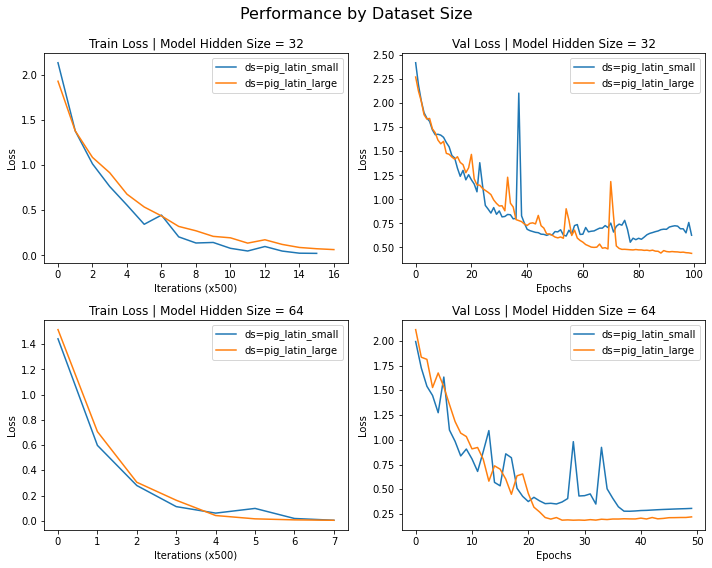

<Figure size 432x288 with 0 Axes>

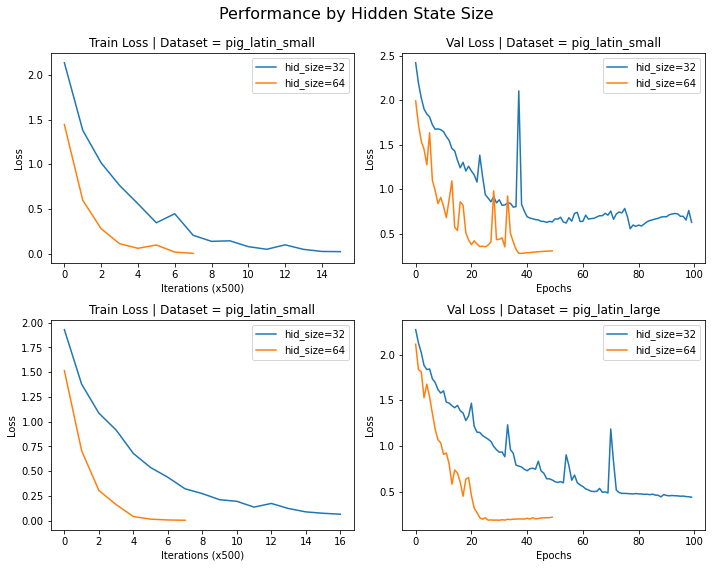

In [ ]:
save_loss_comparison_by_dataset(
    trans32_losses_s,
    trans32_losses_l,
    trans64_losses_s,
    trans64_losses_l,
    trans32_args_s,
    trans32_args_l,
    trans64_args_s,
    trans64_args_l,
    "trans_by_dataset",
)
save_loss_comparison_by_hidden(
    trans32_losses_s,
    trans32_losses_l,
    trans64_losses_s,
    trans64_losses_l,
    trans32_args_s,
    trans32_args_l,
    trans64_args_s,
    trans64_args_l,
    "trans_by_hidden",
)

# Part 2: Decoder-only NMT

## Training and evaluation code

In [ ]:
# Get Decoder Params
def transformer_params(vocab_size, hidden_size, num_layers, max_seq_len=1000):
    """ Given transformerEncoder config calculate total number of parameters """
    # token and position embeddings
    embeddings = vocab_size * hidden_size + max_seq_len * hidden_size
    # attention
    self_attention = 3 * hidden_size**2 + 3 * hidden_size
    attention_mlp = hidden_size**2 + hidden_size
    # out
    out = hidden_size * vocab_size + vocab_size
    # note: embeddings are not included in the param count!
    total_params = num_layers * (self_attention + attention_mlp) + out
    return total_params


# Let us use a factor of 2 to describe the multiply accumulate cost. 
# See more details in https://arxiv.org/pdf/2203.15556.pdf Appendix F
# Get Decoder Flops
def transformer_flops(seq_len, vocab_size, hidden_size, num_layers):
    """ Given AttentionEncoder config calculate total number of parameters """
    # token and position embeddings
    embeddings = 2 * seq_len * vocab_size * hidden_size
    # attention
    # key, query, value projections
    attention = 2 * 3 * seq_len * hidden_size * hidden_size
    # key @ query logits
    attlogits = 2 * seq_len * seq_len * hidden_size
    # softmax
    attsoftmax = 3 * seq_len * seq_len # 3 * is for subtract (max), exp, divide (?)
    # softmax @ value reductions
    attvalue = 2 * seq_len * seq_len * hidden_size
    # mlp
    attlinear = 2 * seq_len * hidden_size * hidden_size
    att = attention + attlogits + attsoftmax + attvalue + attlinear

    # out
    out = 2 * seq_len * vocab_size * hidden_size

    # note: we ignore the embedding for now
    forward_flops = num_layers * att + out
    backward_flops = 2 * forward_flops # as in Kaplan et al. 2020
    total_flops = forward_flops + backward_flops
    return total_flops

def string_to_index_list(s, char_to_index, end_token=None):
    """Converts a sentence into a list of indexes (for each character)."""
    # return [char_to_index[char] for char in s] + [
    #     end_token
    # ]  # Adds the end token to each index list

    if end_token is not None:
        return [char_to_index[char] for char in s] + [
            end_token
        ]  # Adds the end token to each index list
    else:
        return [char_to_index[char] for char in s]


def translate_sentence(sentence, decoder, idx_dict, opts):
    """Translates a sentence from English to Pig-Latin, by splitting the sentence into
    words (whitespace-separated), running the decoder model to translate each
    word independently, and then stitching the words back together with spaces between them.
    """
    if idx_dict is None:
        line_pairs, vocab_size, idx_dict = load_data(opts["data_file_name"])
    return " ".join(
        [translate(word, decoder, idx_dict, opts) for word in sentence.split()]
    )


def translate(input_string, decoder, idx_dict, opts):
    """Translates a given string from English to Pig-Latin."""
    char_to_index = idx_dict["char_to_index"]
    index_to_char = idx_dict["index_to_char"]
    start_token = idx_dict["start_token"]
    end_token = idx_dict["end_token"]
    end_prompt_token = idx_dict["end_prompt_token"]

    max_generated_chars = 20
    gen_string = ""

    indexes = string_to_index_list(input_string, char_to_index, end_prompt_token)
    indexes = to_var(
        torch.LongTensor(indexes).unsqueeze(0), opts.cuda
    )  # Unsqueeze to make it like BS = 1

    # decoder_hidden = encoder_last_hidden
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_input = torch.cat([decoder_input, indexes], dim=1)

    decoder_inputs = decoder_input
    out_start_idx = len(decoder_inputs[0]) - 1
    for i in range(max_generated_chars):
        ## slow decoding, recompute everything at each time
        decoder_outputs, attention_weights = decoder(
            decoder_inputs
        )

        generated_words_all = F.softmax(decoder_outputs, dim=2).max(2)[1]
        generated_words = generated_words_all[:, out_start_idx:]
        ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
        ni = ni[-1]  # latest output token
      
        decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)

        if ni == end_token:
            break
        else:
            gen_string = "".join(
                [
                    index_to_char[int(item)]
                    for item in generated_words.cpu().numpy().reshape(-1)
                ]
            )

    return gen_string

def visualize_attention(input_string, encoder, decoder, idx_dict, opts):
    """Generates a heatmap to show where attention is focused in each decoder step."""
    if idx_dict is None:
        line_pairs, vocab_size, idx_dict = load_data(opts["data_file_name"])
    char_to_index = idx_dict["char_to_index"]
    index_to_char = idx_dict["index_to_char"]
    start_token = idx_dict["start_token"]
    end_token = idx_dict["end_token"]

    max_generated_chars = 20
    gen_string = ""

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(
        torch.LongTensor(indexes).unsqueeze(0), opts.cuda
    )  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_hidden = encoder(indexes)

    decoder_hidden = encoder_hidden
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    produced_end_token = False

    for i in range(max_generated_chars):
        ## slow decoding, recompute everything at each time
        decoder_outputs, attention_weights = decoder(
            decoder_inputs, encoder_annotations, decoder_hidden
        )
        generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
        ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
        ni = ni[-1]  # latest output token

        decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)

        if ni == end_token:
            break
        else:
            gen_string = "".join(
                [
                    index_to_char[int(item)]
                    for item in generated_words.cpu().numpy().reshape(-1)
                ]
            )

    if isinstance(attention_weights, tuple):
        ## transformer's attention mweights
        attention_weights, self_attention_weights = attention_weights

    all_attention_weights = attention_weights.data.cpu().numpy()

    for i in range(len(all_attention_weights)):
        attention_weights_matrix = all_attention_weights[i].squeeze()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(attention_weights_matrix, cmap="bone")
        fig.colorbar(cax)

        # Set up axes
        ax.set_yticklabels([""] + list(input_string) + ["EOS"], rotation=90)
        ax.set_xticklabels(
            [""] + list(gen_string) + (["EOS"] if produced_end_token else [])
        )

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        # Add title
        plt.xlabel("Attention weights to the source sentence in layer {}".format(i + 1))
        plt.tight_layout()
        plt.grid("off")
        plt.show()

    return gen_string

def compute_loss(data_dict, decoder, idx_dict, criterion, optimizer, opts):
    """Train/Evaluate the model on a dataset.

    Arguments:
        data_dict: The validation/test word pairs, organized by source and target lengths.
        decoder: A decoder model (with or without attention) to generate output tokens.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Train the weights if an optimizer is given. None if only evaluate the model.
        opts: The command-line arguments.

    Returns:
        mean_loss: The average loss over all batches from data_dict.
    """
    start_token = idx_dict["start_token"]
    end_token = idx_dict["end_token"]
    end_prompt_token = idx_dict["end_prompt_token"]
    char_to_index = idx_dict["char_to_index"]

    losses = []
    num_tokens = 0
    num_flops = 0
    num_example = 0
    for key in data_dict:
        input_strings, target_strings = zip(*data_dict[key])
        input_tensors = [
            torch.LongTensor(string_to_index_list(s, char_to_index, end_prompt_token))
            for s in input_strings
        ]
        target_tensors = [
            torch.LongTensor(string_to_index_list(s, char_to_index, end_token))
            for s in target_strings
        ]

        num_tensors = len(input_tensors)
        num_batches = int(np.ceil(num_tensors / float(opts.batch_size)))

        for i in range(num_batches):
            start = i * opts.batch_size
            end = start + opts.batch_size

            src_EOP = to_var(torch.stack(input_tensors[start:end]), opts.cuda)
            tgt_EOS = to_var(torch.stack(target_tensors[start:end]), opts.cuda)
            tgt_EOS_len = tgt_EOS.size(1)  

            SOS_src_EOP_tgt, src_EOP_tgt_EOS = generate_tensors_for_training_decoder_nmt(src_EOP, tgt_EOS, start_token, opts.cuda)

            predict_src_EOP_tgt_EOS, attention_weights = decoder(SOS_src_EOP_tgt)

            predict_tgt_EOS = predict_src_EOP_tgt_EOS[:, -tgt_EOS_len:, :]
            predict_tgt_EOS_flatten = predict_tgt_EOS.reshape(-1, predict_tgt_EOS.size(2))
            tgt_EOS_flatten = tgt_EOS.view(-1)
            loss = criterion(predict_tgt_EOS_flatten, tgt_EOS_flatten)
           
            losses.append(loss.item())

            # Collect some statistics
            BS = src_EOP.size(0) 
            i_seq_len = SOS_src_EOP_tgt.size(1) 
            num_tokens += BS * i_seq_len
            num_flops += BS * transformer_flops(i_seq_len, opts.vocab_size, opts.hidden_size, opts.num_layers)
            num_example += BS

            ## training if an optimizer is provided
            if optimizer:
                # Zero gradients
                optimizer.zero_grad()
                # Compute gradients
                loss.backward()
                # Update the parameters of the encoder and decoder
                optimizer.step()

    return losses, num_tokens, num_flops, num_example


def training_loop(
    train_dict, val_dict, idx_dict, decoder, criterion, optimizer, opts
):
    """Runs the main training loop; evaluates the model on the val set every epoch.
        * Prints training and val loss each epoch.
        * Prints qualitative translation results each epoch using TEST_SENTENCE
        * Saves an attention map for TEST_WORD_ATTN each epoch
        * Returns loss curves for comparison

    Arguments:
        train_dict: The training word pairs, organized by source and target lengths.
        val_dict: The validation word pairs, organized by source and target lengths.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        decoder: A decoder model (with or without attention) to generate output tokens.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Implements a step rule to update the parameters of the encoder and decoder.
        opts: The command-line arguments.

    Returns:
        losses: Lists containing training and validation loss curves.
    """

    start_token = idx_dict["start_token"]
    end_token = idx_dict["end_token"]
    char_to_index = idx_dict["char_to_index"]

    loss_log = open(os.path.join(opts.checkpoint_path, "loss_log.txt"), "w")

    best_val_loss = 1e6
    train_losses = []
    val_losses = []

    mean_train_losses = []
    mean_val_losses = []

    early_stopping_counter = 0

    num_tokens = []
    num_flops = []
    num_examples = []
    num_params = []

    total_tokens = 0
    total_flops = 0
    total_examples = 0
    params_count = transformer_params(opts.vocab_size, opts.hidden_size, opts.num_layers)


    for epoch in range(opts.nepochs):
        optimizer.param_groups[0]["lr"] *= opts.lr_decay

        train_loss, num_token, num_flop, num_example = compute_loss(
            train_dict, decoder, idx_dict, criterion, optimizer, opts
        )
        val_loss, _, _, _ = compute_loss(
            val_dict, decoder, idx_dict, criterion, None, opts
        )

        mean_train_loss = np.mean(train_loss)
        mean_val_loss = np.mean(val_loss)

        if mean_val_loss < best_val_loss:
            checkpoint(decoder, idx_dict, opts)
            best_val_loss = mean_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > opts.early_stopping_patience:
            print(
                "Validation loss has not improved in {} epochs, stopping early".format(
                    opts.early_stopping_patience
                )
            )
            print("Obtained lowest validation loss of: {}".format(best_val_loss))
            return (mean_train_losses, mean_val_losses, num_tokens, num_flops, num_examples, num_params)

        gen_string = translate_sentence(TEST_SENTENCE, decoder, idx_dict, opts)
        total_tokens += num_token
        total_flops += num_flop
        total_examples += num_example

        print(
            "Epoch: {:3d} | Flops (T): {}, Tokens (M) {}, Train Loss {:.3f}, Val Loss {:.3f} | Gen: {:20s}".format(
                epoch, total_flops/1e12, total_tokens/1e6,
                mean_train_loss, mean_val_loss, gen_string)
        )

        loss_log.write("{} {} {}\n".format(epoch, train_loss, val_loss))
        loss_log.flush()

        train_losses += train_loss
        val_losses += val_loss

        mean_train_losses.append(mean_train_loss)
        mean_val_losses.append(mean_val_loss)
        num_tokens.append(total_tokens)
        num_flops.append(total_flops)
        num_examples.append(total_examples)
        num_params.append(params_count)
        
    print("Obtained lowest validation loss of: {}".format(best_val_loss))
    print("Avg tokens per example (Seq Len): {}, Avg flops per example: {}".format(
        total_tokens/total_examples, total_flops/total_examples))
    return (mean_train_losses, mean_val_losses, num_tokens, num_flops, num_examples, num_params)

def train(opts):
    line_pairs, vocab_size, idx_dict = load_data(opts["data_file_name"])
    print_data_stats(line_pairs, vocab_size, idx_dict)

    # Split the line pairs into an 80% train and 20% val split
    num_lines = len(line_pairs)
    num_train = int(0.8 * num_lines)
    train_pairs, val_pairs = line_pairs[:num_train], line_pairs[num_train:]

    # Group the data by the lengths of the source and target words, to form batches
    train_dict = create_dict(train_pairs)
    val_dict = create_dict(val_pairs)
    print(train_dict)

    ##########################################################################
    ### Setup: Create Decoder, Learning Criterion, and Optimizers ###
    ##########################################################################
    decoder = TransformerDecoder(
        vocab_size=vocab_size,
        hidden_size=opts.hidden_size,
        num_layers=opts.num_transformer_layers,
        loss_seq_span=opts.loss_seq_span
    )

    #### setup checkpoint path
    model_name = "decoder-only-h{}-bs{}-{}".format(
        opts.hidden_size, opts.batch_size, opts.data_file_name
    )
    opts.checkpoint_path = model_name
    create_dir_if_not_exists(opts.checkpoint_path)
    ####

    if opts.cuda:
        decoder.cuda()
        print("Moved models to GPU!")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        list(decoder.parameters()), lr=opts.learning_rate
    )

    try:
        losses = training_loop(
            train_dict, val_dict, idx_dict, decoder, criterion, optimizer, opts
        )
    except KeyboardInterrupt:
        print("Exiting early from training.")
        return decoder, losses

    return decoder, losses, idx_dict


def print_data_stats(line_pairs, vocab_size, idx_dict):
    """Prints example word pairs, the number of data points, and the vocabulary."""
    print("=" * 80)
    print("Data Stats".center(80))
    print("-" * 80)
    for pair in line_pairs[:5]:
        print(pair)
    print("Num unique word pairs: {}".format(len(line_pairs)))
    print("Vocabulary: {}".format(idx_dict["char_to_index"].keys()))
    print("Vocab size: {}".format(vocab_size))
    print("=" * 80)


def print_opts(opts):
    """Prints the values of all command-line arguments."""
    print("=" * 80)
    print("Opts".center(80))
    print("-" * 80)
    for key in opts.__dict__:
        print("{:>30}: {:<30}".format(key, opts.__dict__[key]).center(80))
    print("=" * 80)


def checkpoint(decoder, idx_dict, opts):
    """Saves the decoder model, along with idx_dict, which
    contains the char_to_index and index_to_char mappings, and the start_token
    and end_token values.
    """
    with open(os.path.join(opts.checkpoint_path, "decoder.pt"), "wb") as f:
        torch.save(decoder, f)

    with open(os.path.join(opts.checkpoint_path, "idx_dict.pkl"), "wb") as f:
        pkl.dump(idx_dict, f)

## Step 1: Construct the input tensors and the target tensors for training a decoder
Implement the function below by following the three steps mentioned.

In [ ]:
def generate_tensors_for_training_decoder_nmt(src_EOP, tgt_EOS, start_token, cuda):
    src_EOP_tgt_EOS = torch.cat((src_EOP, tgt_EOS), dim=1)
    
    sos_vector = torch.ones(src_EOP.size(0), 1).long() * start_token
    sos_vector = to_var(sos_vector, cuda)

    SOS_src_EOP_tgt = torch.cat((sos_vector, src_EOP_tgt_EOS), dim=1)[ : , :-1]

    return SOS_src_EOP_tgt, src_EOP_tgt_EOS

In [ ]:
# trails
use_cuda = torch.cuda.is_available()
opts = AttrDict()
args_dict = {
    "data_file_name": "pig_latin_small", #pig_latin_small debug
    "cuda": use_cuda,
    "nepochs": 100,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 100,
    "lr_decay": 0.99,
    "batch_size": 64,
    "hidden_size": 128,
    "num_transformer_layers": 4,
    "loss_seq_span": "target_only",
    "num_layers": 4,
    "vocab_size": 30 
}
opts.update(args_dict)
print_opts(opts)

line_pairs, vocab_size, idx_dict = load_data(opts["data_file_name"])
start_token = idx_dict["start_token"]
end_token = idx_dict["end_token"]
end_prompt_token = idx_dict["end_prompt_token"]
char_to_index = idx_dict["char_to_index"]
print(idx_dict)

num_lines = len(line_pairs)
num_train = int(0.8 * num_lines)
train_pairs, val_pairs = line_pairs[:num_train], line_pairs[num_train:]
# Group the data by the lengths of the source and target words, to form batches
train_dict = create_dict(train_pairs)
val_dict = create_dict(val_pairs)
print("train_dict ", train_dict)

my_key = 0
for key in train_dict:
  my_key = key
  break

input_strings, target_strings = zip(*train_dict[my_key])

input_tensors = [
            torch.LongTensor(string_to_index_list(s, char_to_index, end_prompt_token))
            for s in input_strings]
target_tensors = [
            torch.LongTensor(string_to_index_list(s, char_to_index, end_token))
            for s in target_strings]

i = 0
start = i * opts.batch_size
end = start + opts.batch_size
src_EOP = to_var(torch.stack(input_tensors[start:end]), opts.cuda)
tgt_EOS = to_var(torch.stack(target_tensors[start:end]), opts.cuda)
print("src_EOP ", src_EOP[:10])
print("tgt_EOS ", tgt_EOS[:10])

SOS_src_EOP_tgt, src_EOP_tgt_EOS = generate_tensors_for_training_decoder_nmt(src_EOP, tgt_EOS, start_token, opts.cuda)

for j in range(10):
  print("SOS_src_EOP_tgt: ", SOS_src_EOP_tgt[j])
  print("src_EOP_tgt_EOS: ", src_EOP_tgt_EOS[j])

 # 'SOS': 27, 'EOS': 28, 'EOP': 29 

 # SOS (27) ... EOP (29) ...
 # ... EOP (29) ... EOS (28)

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 128                                    
                 num_transformer_layers: 4                                      
                          lo

## Step 2: Implement decoder forward pass

The following cell defines the decoder only transformer.  You can check the forward function implementation from the encoder-decoder model ot get an idea of how to implement this.

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, loss_seq_span):
        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.num_layers = num_layers

        self.self_attentions = nn.ModuleList(
            [
                CausalScaledDotAttention(
                    hidden_size=hidden_size,
                )
                for i in range(self.num_layers)
            ]
        )
        
        self.attention_mlps = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU(),
                )
                for i in range(self.num_layers)
            ]
        )
        self.out = nn.Linear(hidden_size, vocab_size)

        self.positional_encodings = self.create_positional_encodings()
        self.loss_seq_span = loss_seq_span

    def forward(self, inputs):
        """Forward pass of the attention-based decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """
        batch_size, seq_len = inputs.size()
        # Get the embeddings for the inputs
        embed = self.embedding(inputs) # batch_size x seq_len x hidden_size
        # Add the positional encodings to the embeddings
        embeddings = embeddings + self.positional_encodings[:seq_len]
        # Apply the self-attention layers
        self_attention_weights_list = []
        contexts = embeddings
        for i in range(self.num_layers):
            new_contexts, self_attention_weights = self.self_attentions[i](
                contexts, contexts, contexts
            )  # batch_size x seq_len x hidden_size
            residual_contexts = contexts + new_contexts

            # Apply the attention MLP layers
            new_contexts = self.attention_mlps[i](residual_contexts)
            contexts = residual_contexts + new_contexts

            self_attention_weights_list.append(self_attention_weights)

        # Apply the output layer
        output = self.out(contexts)

        # Stack the self-attention weights across all the layers
        self_attention_weights = torch.stack(self_attention_weights_list)

        # Return the output and the attention weights
        return output, self_attention_weights

    def create_positional_encodings(self, max_seq_len=1000):
        """Creates positional encodings for the inputs.

        Arguments:
            max_seq_len: a number larger than the maximum string length we expect to encounter during training

        Returns:
            pos_encodings: (max_seq_len, hidden_dim) Positional encodings for a sequence with length max_seq_len.
        """
        pos_indices = torch.arange(max_seq_len)[..., None]
        dim_indices = torch.arange(self.hidden_size // 2)[None, ...]
        exponents = (2 * dim_indices).float() / (self.hidden_size)
        trig_args = pos_indices / (10000 ** exponents)
        sin_terms = torch.sin(trig_args)
        cos_terms = torch.cos(trig_args)

        pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
        pos_encodings[:, 0::2] = sin_terms
        pos_encodings[:, 1::2] = cos_terms

        if torch.cuda.is_available():
            pos_encodings = pos_encodings.cuda()

        return pos_encodings

## Step 3: Train the decoder-only model
Run the following block to see the training and validation loss of a decoder-only transformer.  How is the quality of the generated translation?

In [ ]:
TEST_SENTENCE = "the air conditioning is working"
trans_args_s = AttrDict()
args_dict = {
    "data_file_name": "pig_latin_small", #pig_latin_small debug
    "cuda": use_cuda,
    "nepochs": 100,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 100,
    "lr_decay": 0.99,
    "batch_size": 64,
    "hidden_size": 128,
    "num_transformer_layers": 4,
    "loss_seq_span": "target_only",
    "num_layers": 4,
    "vocab_size": 30 
}
trans_args_s.update(args_dict)
print_opts(trans_args_s)
trans_decoder_s, trans_losses_s, idx_dict = train(trans_args_s)


                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 128                                    
                 num_transformer_layers: 4                                      
                          lo

In [ ]:
TEST_SENTENCE = "the air conditioning is working"
translated = translate_sentence(
    TEST_SENTENCE,  trans_decoder_s, None, trans_args_s
)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the air conditioning is working 
translated:	ea aa a aa a


# Part 3: Compute Optimal Model

Now we will train a set of decoder only transformer models to investigate the compute optimal model.

## Step 1: Model training
- Let's train six models of different model sizes.

In [ ]:
TEST_SENTENCE = "floor"
trans16_args_s = AttrDict()
args_dict_16 = {
    "data_file_name": "pig_latin_small", #pig_latin_small debug
    "cuda": use_cuda,
    "nepochs": 100,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 100,
    "lr_decay": 0.99,
    "batch_size": 64,
    "hidden_size": 16,
    "num_transformer_layers": 4,
    "loss_seq_span": "target_only",
    "num_layers": 4,
    "vocab_size": 30 
}
trans16_args_s.update(args_dict_16)
print_opts(trans16_args_s)
trans16_decoder_s, trans16_losses_s, idx_dict = train(trans16_args_s)

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 16                                     
                 num_transformer_layers: 4                                      
                          lo

In [ ]:
TEST_SENTENCE = "floor"
trans32_args_s = AttrDict()
args_dict_32 = {
    "data_file_name": "pig_latin_small", #pig_latin_small debug
    "cuda": use_cuda,
    "nepochs": 100,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 100,
    "lr_decay": 0.99,
    "batch_size": 64,
    "hidden_size": 32,
    "num_transformer_layers": 4,
    "loss_seq_span": "target_only",
    "num_layers": 4,
    "vocab_size": 30 
}
trans32_args_s.update(args_dict_32)
print_opts(trans32_args_s)
trans32_decoder_s, trans32_losses_s, idx_dict = train(trans32_args_s)

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 32                                     
                 num_transformer_layers: 4                                      
                          lo

In [ ]:
TEST_SENTENCE = "floor"
trans48_args_s = AttrDict()
args_dict_48 = {
    "data_file_name": "pig_latin_small", #pig_latin_small debug
    "cuda": use_cuda,
    "nepochs": 100,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 100,
    "lr_decay": 0.99,
    "batch_size": 64,
    "hidden_size": 48,
    "num_transformer_layers": 4,
    "loss_seq_span": "target_only",
    "num_layers": 4,
    "vocab_size": 30 
}
trans48_args_s.update(args_dict_48)
print_opts(trans48_args_s)
trans48_decoder_s, trans48_losses_s, idx_dict = train(trans48_args_s)

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 48                                     
                 num_transformer_layers: 4                                      
                          lo

In [ ]:
TEST_SENTENCE = "floor"
trans64_args_s = AttrDict()
args_dict_64 = {
    "data_file_name": "pig_latin_small", #pig_latin_small debug
    "cuda": use_cuda,
    "nepochs": 100,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 100,
    "lr_decay": 0.99,
    "batch_size": 64,
    "hidden_size": 64,
    "num_transformer_layers": 4,
    "loss_seq_span": "target_only",
    "num_layers": 4,
    "vocab_size": 30 
}
trans64_args_s.update(args_dict_64)
print_opts(trans64_args_s)
trans64_decoder_s, trans64_losses_s, idx_dict = train(trans64_args_s)

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 64                                     
                 num_transformer_layers: 4                                      
                          lo

In [ ]:
TEST_SENTENCE = "floor"
trans96_args_s = AttrDict()
args_dict_96 = {
    "data_file_name": "pig_latin_small", #pig_latin_small debug
    "cuda": use_cuda,
    "nepochs": 100,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 100,
    "lr_decay": 0.99,
    "batch_size": 64,
    "hidden_size": 96,
    "num_transformer_layers": 4,
    "loss_seq_span": "target_only",
    "num_layers": 4,
    "vocab_size": 30 
}
trans96_args_s.update(args_dict_96)
print_opts(trans96_args_s)
trans96_decoder_s, trans96_losses_s, idx_dict = train(trans96_args_s)

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 96                                     
                 num_transformer_layers: 4                                      
                          lo

In [ ]:
TEST_SENTENCE = "floor"
trans128_args_s = AttrDict()
args_dict_128 = {
    "data_file_name": "pig_latin_small", #pig_latin_small debug
    "cuda": use_cuda,
    "nepochs": 100,
    "checkpoint_dir": "checkpoints",
    "learning_rate": 5e-4,
    "early_stopping_patience": 100,
    "lr_decay": 0.99,
    "batch_size": 64,
    "hidden_size": 128,
    "num_transformer_layers": 4,
    "loss_seq_span": "target_only",
    "num_layers": 4,
    "vocab_size": 30 
}
trans128_args_s.update(args_dict_128)
print_opts(trans128_args_s)
trans128_decoder_s, trans128_losses_s, idx_dict = train(trans128_args_s)

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: pig_latin_small                        
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 128                                    
                 num_transformer_layers: 4                                      
                          lo

In [ ]:
def getf_loss_flop(data, degree=5):
    x, y = data[3], data[1]
    p = np.polyfit(x, y, degree)
    return p

def plot_loss_flop_o(data_list, num_params, degree=5):
    fig, ax = plt.subplots(figsize=(6, 5))
    for data, params in zip(data_list, num_params):
        x, y = data[3], data[1]
        ax.plot(x, y, label=f'{params}')

    ax.legend(title='# Params', loc = "lower left")
    plt.xscale('log')
    plt.xlabel('FLOPs')
    plt.ylabel('Val Loss')
    plt.title('Val Loss vs FLOPs') 

def plot_loss_flop(data_list, num_params, degree=5):
    fig, ax = plt.subplots(figsize=(6, 5))
    for data, params in zip(data_list, num_params):
        x, y = data[3], data[1]
        p = np.polyfit(x, y, degree)
        x_min, x_max = min(x), max(x)
        px = np.logspace(np.log10(x_min), np.log10(x_max), 100)
        py = np.polyval(p, px)
        ax.plot(px, py, label=f'{params}')

    ax.legend(title='# Params', loc = "lower left")
    plt.xscale('log')
    plt.xlabel('FLOPs')
    plt.ylabel('Val Loss')
    plt.title('Val Loss (Poly Approx.) vs FLOPs')  

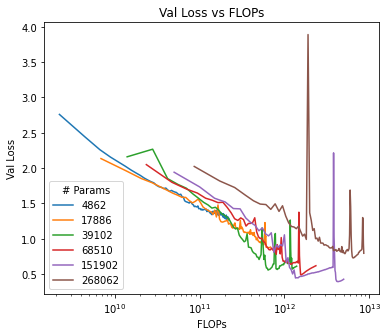

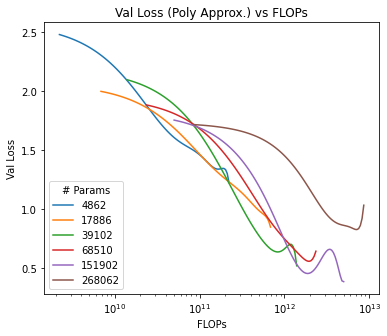

In [ ]:
col_names = ['Train loss', 'Val loss', 'Tokens', 'Flops', 'Number of Examples', 'Number of Parameters']

hidden_list = [16, 32, 48, 64, 96, 128]
num_params = [transformer_params(30, hidden, 4) for hidden in hidden_list]
data_list = [trans16_losses_s, trans32_losses_s, trans48_losses_s, trans64_losses_s, trans96_losses_s, trans128_losses_s]

plot_loss_flop_o(data_list, num_params)
plot_loss_flop(data_list, num_params)

## Step 2: IsoFLOP profiles

In [ ]:
def get_scatter_data(data_list, num_params, f_list, tflops):
    x, y = [], []
    for i, f in enumerate(f_list):
        if tflops <= max(data_list[i][3]) and tflops >= min(data_list[i][3]):
            x.append(num_params[i])
            y.append(np.polyval(f, tflops))
    return x, y


def find_optimal_params(x, y):
    p = np.polyfit(x, y, 2)
    optimal_params = x[np.argmin(np.polyval(p, x))]
    return p, optimal_params

In [ ]:
def plot_isoflop(data_list, num_params, degree=5):
    colors = ['#E41A1C', '#377EB8','#4DAF4A','#984EA3','#FF7F00','#FFFF33','#A65628']
    target_flops = [8e10, 16e10, 32e10, 64e10, 128e10]
    f_list = [getf_loss_flop(data, degree=5) for data in data_list]

    fig, ax = plt.subplots(figsize=(6, 5))
    for fidx, tflops in enumerate(target_flops):
        x, y = get_scatter_data(data_list, num_params, f_list, tflops)
        p, optimal_params = find_optimal_params(x, y)

        ax.scatter(np.array(x), np.array(y), label=f'{tflops/1e12} TFlops', color=colors[fidx])
        px = np.logspace(np.log10(x[0]), np.log10(x[-1]), 100)
        print(px)
        py = np.polyval(p, px) #TODO
        print(py)
        ax.plot(px, py, color=colors[fidx])
        ax.axvline(x=optimal_params, color=colors[fidx], linestyle='--')

    ax.legend(loc = "lower left")
    plt.xscale('log')
    plt.xlabel('# Parameters')
    plt.ylabel('Val Loss')
    plt.title('Val Loss vs # Parameters')  

In [ ]:
x = [1, 2, 3, 4, 5]
y = [-1, 3, 2, 8, 8]
p2 = np.polyfit(x, y, 2)
print(p2)

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(np.array(x), np.array(y))

px = np.logspace(np.log10(x[0]), np.log10(x[-1]), 100)
print(px)
py = np.polyval(p2, np.log10(px))
print(py)
ax.plot(px, py)

In [ ]:
plot_isoflop(data_list, num_params)

## Step 3: Parameters vs FLOPs

In [ ]:
def fit_linear_log(x, y):
    m, c = np.polyfit(np.log10(x), y, 1)
    return m, c


In [ ]:
def plot_flops_params(data_list, num_params):
    colors = ['#E41A1C', '#377EB8','#4DAF4A','#984EA3','#FF7F00','#FFFF33','#A65628']
    target_flops = [8e10, 16e10, 32e10, 64e10, 128e10]
    f_list = [getf_loss_flop(data, degree=5) for data in data_list]

    fig, ax = plt.subplots(figsize=(6, 5))
    params = []
    for fidx, tflops in enumerate(target_flops):
        x, y = get_scatter_data(data_list, num_params, f_list, tflops)
        p, optimal_params = find_optimal_params(x, y)
        params.append(optimal_params)

    ax.scatter(target_flops, params)
    m, c = fit_linear_log(target_flops, params)
    print(f"y = {m}x + {c}")

    lx = np.logspace(np.log10(1e10), np.log10(1e15), 100)
    ly = 10**(np.log10(lx) * m + c) # TODO
    ax.plot(lx, ly, color = colors[0])

    ax.legend(loc = "lower left")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('FLOPs')
    plt.ylabel('# Parameters')
    plt.xlim()
    plt.title('Compute Optimal Models') 
    plt.grid()

<ipython-input-78-e41491cbab9b>:18: RuntimeWarning: overflow encountered in power
  ly = 10**(np.log10(lx) * m + c)


y = 102017.7405652286x + -1134249.805652285


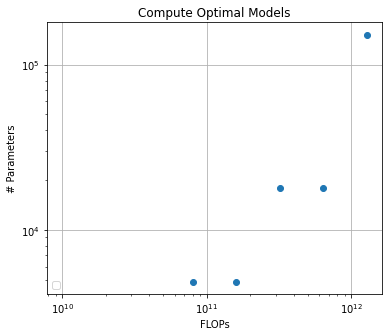

In [ ]:
plot_flops_params(data_list, num_params)

## Step 4: Tokens vs FLOPs

In [ ]:
from scipy.optimize import bisect

def find_hidden(params, x_min=16, x_max=1e4, tol=1e-4):
    f = lambda h: transformer_params(vocab_size=30, hidden_size=h, num_layers=4)
    # Define the function to find the root of
    def g(x):
        return f(x) - params
    
    # Find the root of the function using the bisection method
    x_root = bisect(g, x_min, x_max, rtol=tol)
    return x_root

def find_tokens(params, flops, seq_len):
    hidden = find_hidden(params)
    flops_per_example = transformer_flops(seq_len=seq_len, vocab_size=30, 
                                          hidden_size=hidden, num_layers=4)
    return flops/flops_per_example * seq_len

def plot_flops_tokens(data_list, num_params):
    seq_len = 19.55
    colors = ['#E41A1C', '#377EB8','#4DAF4A','#984EA3','#FF7F00','#FFFF33','#A65628']
    target_flops = [8e10, 16e10, 32e10, 64e10, 128e10]
    f_list = [getf_loss_flop(data, degree=5) for data in data_list]

    fig, ax = plt.subplots(figsize=(6, 5))
    params = []
    tokens = []
    for fidx, tflops in enumerate(target_flops):
        x, y = get_scatter_data(data_list, num_params, f_list, tflops)
        p, optimal_params = find_optimal_params(x, y)
        params.append(optimal_params)
        tokens.append(find_tokens(optimal_params, tflops, seq_len))

    ax.scatter(target_flops, tokens)

    m, c = fit_linear_log(target_flops, tokens)
    print(f"y = {m}x + {c}")

    lx = np.logspace(np.log10(1e10), np.log10(1e15), 100)
    ly = 10**(np.log10(lx) * m + c)
    ax.plot(lx, ly, color = colors[0])

    ax.legend(loc = "lower left")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('FLOPs')
    plt.ylabel('# Tokens')
    plt.title('Compute Optimal Models') 
    plt.grid()

<ipython-input-80-e79cdb9c469d>:40: RuntimeWarning: overflow encountered in power
  ly = 10**(np.log10(lx) * m + c)


y = -28388.661483669184x + 3120685.365304991


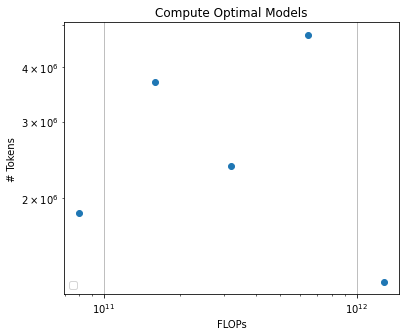

In [ ]:
plot_flops_tokens(data_list, num_params)